<a href="https://colab.research.google.com/github/ryaltic/Modeling-Ranked-Match-Outcomes-Using-Early-Game-Performance-Data-in-League-of-Legends/blob/main/Modeling_Ranked_Matches_Outcomes_LOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Ranked Matches in League of Legends at minute 10

This script will use data from Riot's API to model outcomes of ranked matches to determine how well can League of Legends ranked matches can be predicted in the early game. The matches uses ranked matches from North America region and from Gold to Diamond elo. Another outcome of this script is to see what factors influence ranked matches the most. This script will go through the whole process of the data science workflow with the expection of pulling the data through the API for privacy reason.

## Loading the data and doing Pre-processing

In [ ]:
# Loading the pandas package
import pandas as pd

In [ ]:
# Loading in the data file from my github
matches = pd.read_csv('https://raw.githubusercontent.com/ryaltic/Modeling-Ranked-Match-Outcomes-Using-Early-Game-Performance-Data-in-League-of-Legends/refs/heads/main/league_matches_data.csv')

In [ ]:
# Displaying the first few rows
matches.head()

,match_id,minute,game_duration,blue_win,game_version,Blue_TOP_kills,Blue_TOP_gold,Blue_TOP_xp,Blue_TOP_cs,Blue_TOP_wards_placed,...,Blue__gold,Blue__xp,Blue__cs,Blue__wards_placed,Blue__wards_killed,Red__gold,Red__xp,Red__cs,Red__wards_placed,Red__wards_killed
0,5228482907,5,1666,1,15.3.656.4086,1,1698,2050,22,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5228482907,10,1666,1,15.3.656.4086,0,3262,4551,49,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5228482907,15,1666,1,15.3.656.4086,1,5214,6996,86,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5210847800,5,1848,1,15.1.649.4112,0,1643,1648,13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5210847800,10,1848,1,15.1.649.4112,0,3236,4174,44,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each match contains three data points and shows all information about the match at that current moment. There are a few columns that has information about the game not pertaining to that current moment in time which are game duration, the team that won, the game version and match id. The columns are named well but there will need to be some conversions that will need to be done.  

In [ ]:
# Displaying the columns and column types
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80515 entries, 0 to 80514
Data columns (total 79 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   match_id                   80515 non-null  int64  
 1   minute                     80515 non-null  int64  
 2   game_duration              80515 non-null  int64  
 3   blue_win                   80515 non-null  int64  
 4   game_version               80515 non-null  object 
 5   Blue_TOP_kills             80515 non-null  int64  
 6   Blue_TOP_gold              80515 non-null  int64  
 7   Blue_TOP_xp                80515 non-null  int64  
 8   Blue_TOP_cs                80515 non-null  int64  
 9   Blue_TOP_wards_placed      80515 non-null  int64  
 10  Blue_TOP_wards_killed      80515 non-null  int64  
 11  Blue_JUNGLE_kills          80515 non-null  int64  
 12  Blue_JUNGLE_gold           80515 non-null  int64  
 13  Blue_JUNGLE_xp             80515 non-null  int

Most of the columns are numeric and there are a few columns that have a majority of the data missing which will be dropped. The columns that are going to be dropped are team totals that can be remade.

In [ ]:
# Displaying the shape of the df
matches.shape

(80515, 79)

There are a total of 80,515 rows and 79 columns from the csv file. There is around 27,000 individual matches.

In [ ]:
# Dropping the columns that were majority missing
matches = matches.drop(labels= ['Blue__gold', 'Blue__xp', 'Blue__cs', 'Blue__wards_placed', 'Blue__wards_killed',
                                'Red__gold', 'Red__xp', 'Red__cs', 'Red__wards_placed', 'Red__wards_killed'],
                        axis = 1)

In [ ]:
# Only keeping rows that are at 10 minutes
matches_10 = matches[matches['minute'] == 10]
print(matches_10.head())
print(matches_10.shape)

      match_id  minute  game_duration  blue_win    game_version  \
1   5228482907      10           1666         1   15.3.656.4086   
4   5210847800      10           1848         1   15.1.649.4112   
7   5208847505      10           1484         1   15.1.649.4112   
10  5197140868      10           2007         1  14.24.644.2327   
13  5197107354      10           1857         1  14.24.644.2327   

    Blue_TOP_kills  Blue_TOP_gold  Blue_TOP_xp  Blue_TOP_cs  \
1                0           3262         4551           49   
4                0           3236         4174           44   
7                0           4085         5173           85   
10               0           2542         4280           36   
13               1           4177         4976           75   

    Blue_TOP_wards_placed  ...  Red_UTILITY_kills  Red_UTILITY_gold  \
1                       0  ...                  0              3116   
4                       0  ...                  0              2448   
7    

26,833 rows after filtering to matches at 10 minute time frame

In [ ]:
# Checking for duplicate matches
matches_10.duplicated(subset = 'match_id').sum()

np.int64(0)

No duplicate matches

In [ ]:
# Dropping more columns that are no longer needed
matches_10 = matches_10.drop(labels = ['minute','game_version','match_id','game_duration'], axis = 1)

Minute is no longer needed now that all games are 10 minutes, game version isn't need as the dataset doesn't have champions so the game version doesn't give any information. After checking for duplicated match_id is not needed anymore and game_duration was removed because it gave information about the game after the game was over.

In [ ]:
# Redefining the target variable for more clarity
matches_10['winner'] = matches_10['blue_win'].map({1: 'Blue', 0: 'Red'})

matches_10 = matches_10.drop(labels = ['blue_win'], axis = 1)

In [ ]:
# Filtering out rows that are not legit
print(matches_10.shape)
matches_10 = matches_10[matches_10['Blue_TOP_gold'] >= 1000]
matches_10 = matches_10[matches_10['Blue_TOP_xp'] != 0]
matches_10 = matches_10[matches_10['Red_TOP_gold'] >= 1000]
matches_10 = matches_10[matches_10['Red_TOP_xp'] != 0]
matches_10 = matches_10[matches_10['Blue_JUNGLE_gold'] >= 1000]
matches_10 = matches_10[matches_10['Blue_JUNGLE_xp'] != 0]
matches_10 = matches_10[matches_10['Red_JUNGLE_gold'] >= 1000]
matches_10 = matches_10[matches_10['Red_JUNGLE_xp'] != 0]
matches_10 = matches_10[matches_10['Blue_MIDDLE_gold'] >= 1000]
matches_10 = matches_10[matches_10['Blue_MIDDLE_xp'] != 0]
matches_10 = matches_10[matches_10['Red_MIDDLE_gold'] >= 1000]
matches_10 = matches_10[matches_10['Red_MIDDLE_xp'] != 0]
matches_10 = matches_10[matches_10['Blue_BOTTOM_gold'] >= 1000]
matches_10 = matches_10[matches_10['Blue_BOTTOM_xp'] != 0]
matches_10 = matches_10[matches_10['Red_BOTTOM_gold'] >= 1000]
matches_10 = matches_10[matches_10['Red_BOTTOM_xp'] != 0]
matches_10 = matches_10[matches_10['Blue_UTILITY_gold'] >= 1000]
matches_10 = matches_10[matches_10['Blue_UTILITY_xp'] != 0]
matches_10 = matches_10[matches_10['Red_UTILITY_gold'] >= 1000]
matches_10 = matches_10[matches_10['Red_UTILITY_xp'] != 0]
print(matches_10.shape)


(26833, 65)
(26827, 65)


Removed matches that had a person on the team have less than 1000 gold or 0 XP as that match might not be pulled in correctly as it is impossible to be a legit match while have less than 1000 gold or 0 XP. The filtering removed 6 matches from the dataset.

## Splitting into Training and Testing Sets

In [ ]:
# Defining the x and y datasets
X = matches_10.drop(labels = ['winner'], axis = 1)
y = matches_10['winner']

In [ ]:
# Importing the necessary package
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

## Distribution Checks

In [ ]:
# Checking the distribuation of the y data sets
print(y_train.value_counts())
print(y_test.value_counts())

winner
Blue    10940
Red     10521
Name: count, dtype: int64
winner
Blue    2787
Red     2579
Name: count, dtype: int64


The distributions for both y datasets are roughly even and the data is balanced for the response variable

In [ ]:
# Checking the distribution of all categorical variables
def categorical_variables_dist(df):
  cat_columns = df.select_dtypes(include = ['object','category','bool']).columns
  for col in cat_columns:
    print(df[col].value_counts())

# Using the function on the train and test for the X data set
print(categorical_variables_dist(X_train))
print(categorical_variables_dist(X_test))

None
None


We have no categorical variables in the X datasets

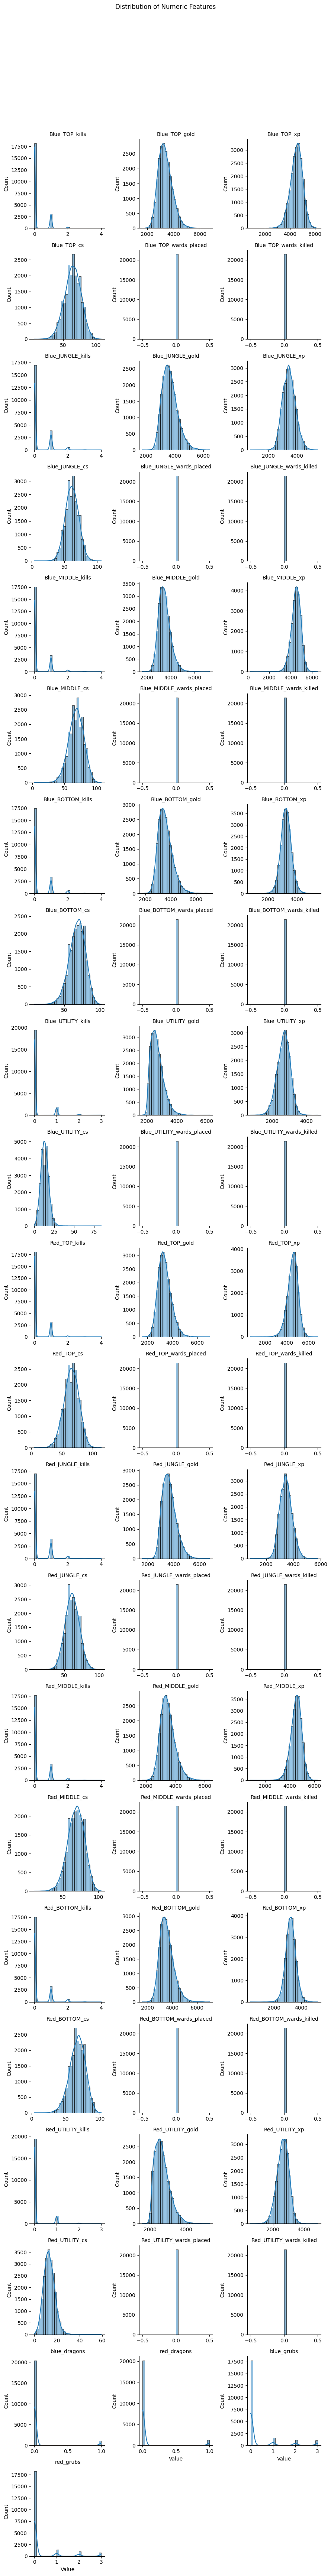

None


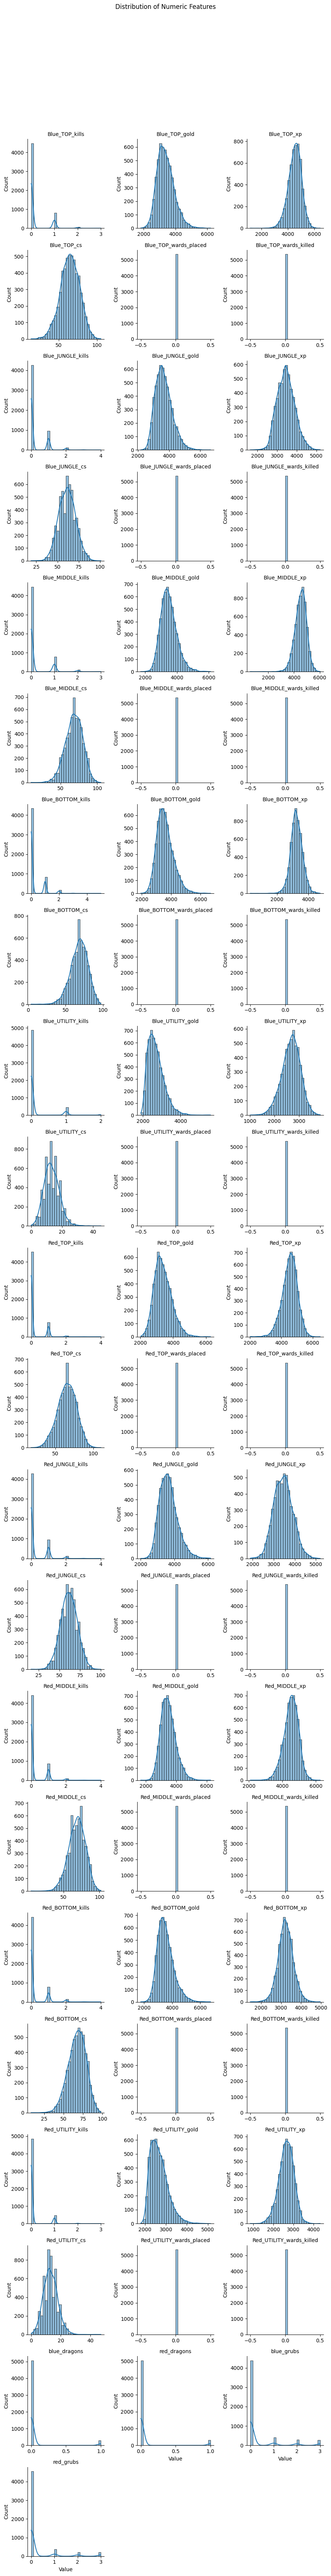

None


In [ ]:
# Importing the needed packages
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a function to plot the distribution of numeric features
def numerical_variables_dist(df, title="Distribution of Numeric Features", col_wrap=3, bins=30, kde=True):
    numeric_columns = df.select_dtypes(include="number") # selecting only numeric columns
    if numeric_columns.empty: # error checking
        print("No numeric columns found.")
        return
    # Melting the columns
    df_long = numeric_columns.melt(var_name="Feature", value_name="Value")

    # Making a facetgrid to display all of the numeric columns
    g = sns.FacetGrid( # assigning the facetgrid to g
        df_long, # using the melted df
        col="Feature",
        col_wrap=col_wrap,
        sharex=False,
        sharey=False
    )

    g.map(sns.histplot, "Value", bins=bins, kde=kde) # using seaborn histogram
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.05)

    plt.show() # showing the plot


# Using the function on the X datasets
print(numerical_variables_dist(X_train))
print(numerical_variables_dist(X_test))


After a brief look through of the numeric variables it is clear that some of the variables did not get pulled correctly so those variables will be dropped.

In [ ]:
# Dropping the variables that didn't pull correctly
X_train = X_train.drop(labels = ['Blue_TOP_cs', 'Red_TOP_cs', 'Blue_JUNGLE_cs', 'Red_JUNGLE_cs','Blue_MIDDLE_cs', 'Red_MIDDLE_cs','Blue_BOTTOM_cs', 'Red_BOTTOM_cs',
                                 'Blue_UTILITY_cs', 'Red_UTILITY_cs', 'Blue_UTILITY_wards_placed', 'Red_UTILITY_wards_placed', 'Blue_BOTTOM_wards_placed', 'Red_BOTTOM_wards_placed',
                                 'Blue_MIDDLE_wards_placed', 'Red_MIDDLE_wards_placed', 'Blue_JUNGLE_wards_placed', 'Red_JUNGLE_wards_placed', 'Blue_TOP_wards_placed', 'Red_TOP_wards_placed',
                                 'Blue_UTILITY_wards_killed', 'Red_UTILITY_wards_killed', 'Blue_BOTTOM_wards_killed', 'Red_BOTTOM_wards_killed',
                                 'Blue_MIDDLE_wards_killed', 'Red_MIDDLE_wards_killed', 'Blue_JUNGLE_wards_killed', 'Red_JUNGLE_wards_killed',
                                 'Blue_TOP_wards_killed', 'Red_TOP_wards_killed'
                                 ], axis = 1)
X_test = X_test.drop(labels = ['Blue_TOP_cs', 'Red_TOP_cs', 'Blue_JUNGLE_cs', 'Red_JUNGLE_cs','Blue_MIDDLE_cs', 'Red_MIDDLE_cs','Blue_BOTTOM_cs', 'Red_BOTTOM_cs',
                                 'Blue_UTILITY_cs', 'Red_UTILITY_cs', 'Blue_UTILITY_wards_placed', 'Red_UTILITY_wards_placed', 'Blue_BOTTOM_wards_placed', 'Red_BOTTOM_wards_placed',
                                 'Blue_MIDDLE_wards_placed', 'Red_MIDDLE_wards_placed', 'Blue_JUNGLE_wards_placed', 'Red_JUNGLE_wards_placed', 'Blue_TOP_wards_placed', 'Red_TOP_wards_placed',
                                 'Blue_UTILITY_wards_killed', 'Red_UTILITY_wards_killed', 'Blue_BOTTOM_wards_killed', 'Red_BOTTOM_wards_killed',
                                 'Blue_MIDDLE_wards_killed', 'Red_MIDDLE_wards_killed', 'Blue_JUNGLE_wards_killed', 'Red_JUNGLE_wards_killed',
                                 'Blue_TOP_wards_killed', 'Red_TOP_wards_killed'
                                 ], axis = 1)

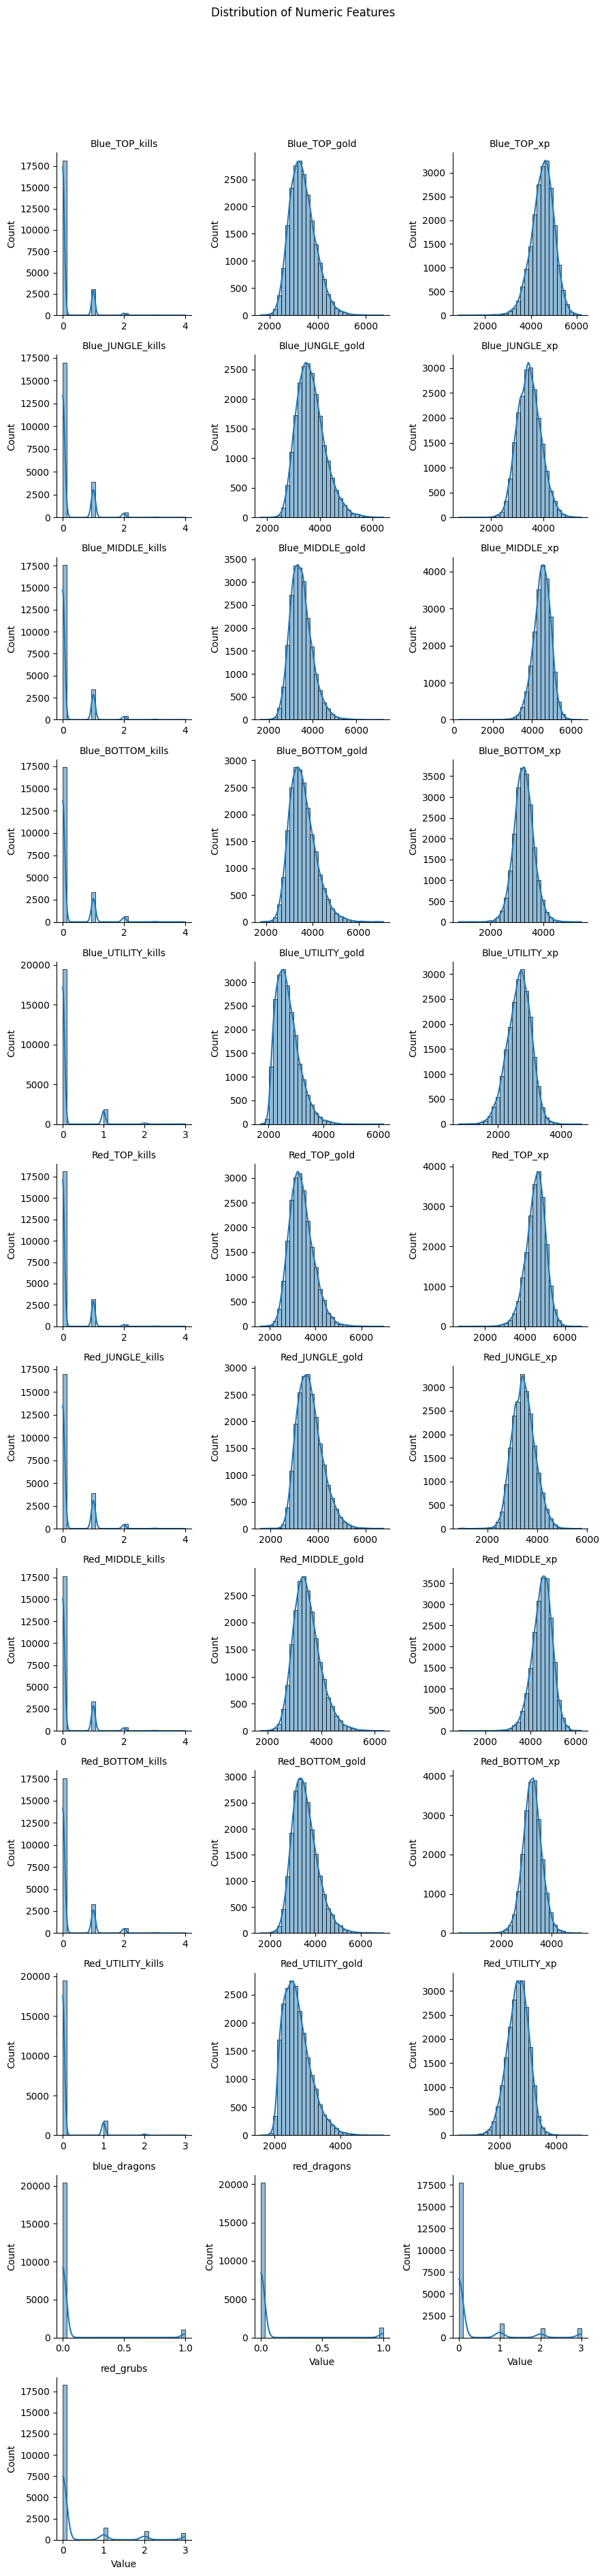

None


In [ ]:
# Checking again
print(numerical_variables_dist(X_train))

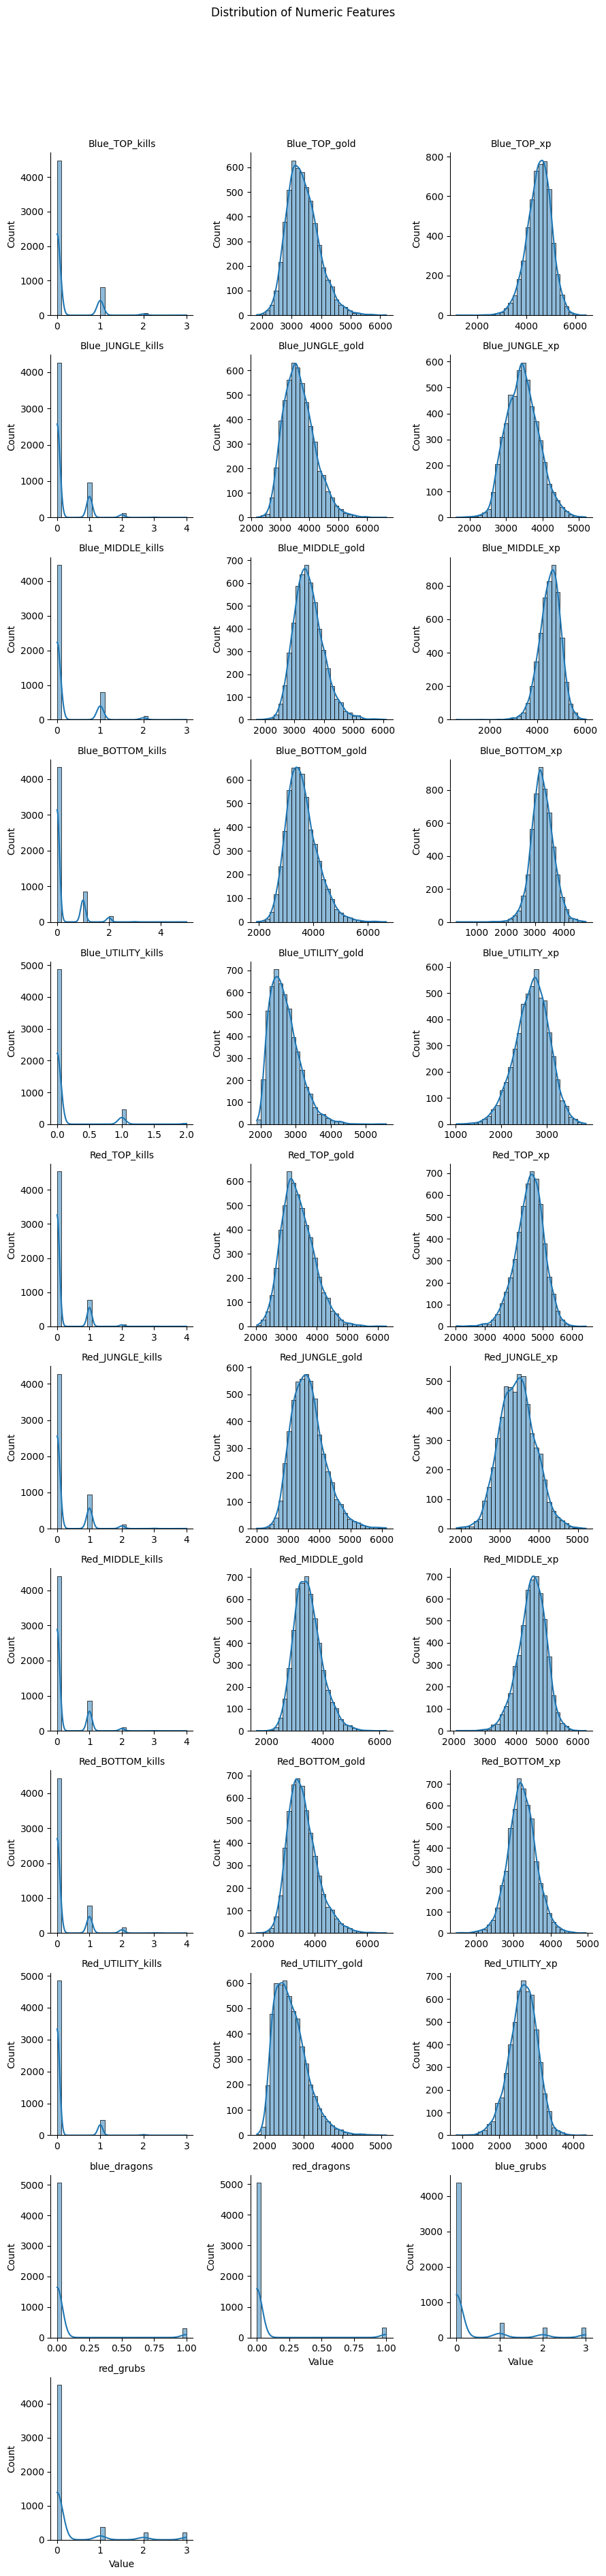

None


In [ ]:
# Checking again
print(numerical_variables_dist(X_test))

The XP and Gold variables for all roles in both dataset are basically evenly distributed with a little tail on the right side meaning there is a slight right skewed for those variables but nothing too major. For the Kills variables we can see for both data set and all roles it is right skewed with most of the data points being at zero. On top of that, the grubs and dragon variables for both data sets and teams are right skewed with most of the data points being at zero. All of the variables and values make logical sense for a Ranked League of Legends match at minute 10 and applying transformations to some of the columns is an option down the line before modeling.


## Feature Engineering

In [ ]:
# Checking if there are any missing values
print(X_train.isna().sum())
print(X_test.isna().sum())

Blue_TOP_kills        0
Blue_TOP_gold         0
Blue_TOP_xp           0
Blue_JUNGLE_kills     0
Blue_JUNGLE_gold      0
Blue_JUNGLE_xp        0
Blue_MIDDLE_kills     0
Blue_MIDDLE_gold      0
Blue_MIDDLE_xp        0
Blue_BOTTOM_kills     0
Blue_BOTTOM_gold      0
Blue_BOTTOM_xp        0
Blue_UTILITY_kills    0
Blue_UTILITY_gold     0
Blue_UTILITY_xp       0
Red_TOP_kills         0
Red_TOP_gold          0
Red_TOP_xp            0
Red_JUNGLE_kills      0
Red_JUNGLE_gold       0
Red_JUNGLE_xp         0
Red_MIDDLE_kills      0
Red_MIDDLE_gold       0
Red_MIDDLE_xp         0
Red_BOTTOM_kills      0
Red_BOTTOM_gold       0
Red_BOTTOM_xp         0
Red_UTILITY_kills     0
Red_UTILITY_gold      0
Red_UTILITY_xp        0
blue_dragons          0
red_dragons           0
blue_grubs            0
red_grubs             0
dtype: int64
Blue_TOP_kills        0
Blue_TOP_gold         0
Blue_TOP_xp           0
Blue_JUNGLE_kills     0
Blue_JUNGLE_gold      0
Blue_JUNGLE_xp        0
Blue_MIDDLE_kills     0
Blu

There are no missing values

In [ ]:
# Defining a new df for team based visuals
Team_df_train = X_train.copy()
Team_df_test = X_test.copy()

In [ ]:
# Creating a list of columns to add together for the blue team
blue_gold_cols = [
    'Blue_TOP_gold',
    'Blue_JUNGLE_gold',
    'Blue_MIDDLE_gold',
    'Blue_BOTTOM_gold',
    'Blue_UTILITY_gold'
]

# Creating a list of columns to add together for the red team
red_gold_cols = [
    'Red_TOP_gold',
    'Red_JUNGLE_gold',
    'Red_MIDDLE_gold',
    'Red_BOTTOM_gold',
    'Red_UTILITY_gold'
]

# Creating total gold variables for each team
Team_df_train['Blue_Total_Gold_10'] = Team_df_train[blue_gold_cols].sum(axis=1)
Team_df_train['Red_Total_Gold_10']  = Team_df_train[red_gold_cols].sum(axis=1)
Team_df_test['Blue_Total_Gold_10'] = Team_df_test[blue_gold_cols].sum(axis=1)
Team_df_test['Red_Total_Gold_10']  = Team_df_test[red_gold_cols].sum(axis=1)

# Finding the gold difference between the team
# Positive = Blue has more gold -- Negative = Red has more gold
Team_df_train['Gold_Difference']  = Team_df_train['Blue_Total_Gold_10'] - Team_df_train['Red_Total_Gold_10']
Team_df_test['Gold_Difference'] = Team_df_test['Blue_Total_Gold_10'] - Team_df_test['Red_Total_Gold_10']

In [ ]:
# Creating a list of columns to add together for the blue team
blue_xp_cols = [
    'Blue_TOP_xp',
    'Blue_JUNGLE_xp',
    'Blue_MIDDLE_xp',
    'Blue_BOTTOM_xp',
    'Blue_UTILITY_xp'
]

# Creating a list of columns to add together for the red team
red_xp_cols = [
    'Red_TOP_xp',
    'Red_JUNGLE_xp',
    'Red_MIDDLE_xp',
    'Red_BOTTOM_xp',
    'Red_UTILITY_xp'
]

# Creating total xp variables for each team
Team_df_train['Blue_Total_Xp_10'] = Team_df_train[blue_xp_cols].sum(axis=1)
Team_df_train['Red_Total_Xp_10']  = Team_df_train[red_xp_cols].sum(axis=1)
Team_df_test['Blue_Total_Xp_10'] = Team_df_test[blue_xp_cols].sum(axis=1)
Team_df_test['Red_Total_Xp_10']  = Team_df_test[red_xp_cols].sum(axis=1)

# Finding the xp difference between the team
# Positive = Blue has more xp -- Negative = Red has more xp
Team_df_train['Xp_Difference']  = Team_df_train['Blue_Total_Xp_10'] - Team_df_train['Red_Total_Xp_10']
Team_df_test['Xp_Difference'] = Team_df_test['Blue_Total_Xp_10'] - Team_df_test['Red_Total_Xp_10']

In [ ]:
# Creating a list of columns to add together for the blue team
blue_kills_cols = [
    'Blue_TOP_kills',
    'Blue_JUNGLE_kills',
    'Blue_MIDDLE_kills',
    'Blue_BOTTOM_kills',
    'Blue_UTILITY_kills'
]

# Creating a list of columns to add together for the red team
red_kills_cols = [
    'Red_TOP_kills',
    'Red_JUNGLE_kills',
    'Red_MIDDLE_kills',
    'Red_BOTTOM_kills',
    'Red_UTILITY_kills'
]

# Creating total kills variables for each team
Team_df_train['Blue_Total_Kills_10'] = Team_df_train[blue_kills_cols].sum(axis=1)
Team_df_train['Red_Total_Kills_10']  = Team_df_train[red_kills_cols].sum(axis=1)
Team_df_test['Blue_Total_Kills_10'] = Team_df_test[blue_kills_cols].sum(axis=1)
Team_df_test['Red_Total_Kills_10']  = Team_df_test[red_kills_cols].sum(axis=1)

# Finding the kills difference between the team
# Positive = Blue has more kills -- Negative = Red has more kills
Team_df_train['Kill_Difference']  = Team_df_train['Blue_Total_Kills_10'] - Team_df_train['Red_Total_Kills_10']
Team_df_test['Kill_Difference'] = Team_df_test['Blue_Total_Kills_10'] - Team_df_test['Red_Total_Kills_10']

In [ ]:
# Changing the columns into difference
X_train['TOP_gold_difference'] = X_train['Blue_TOP_gold'] - X_train['Red_TOP_gold']
X_train['TOP_xp_difference'] = X_train['Blue_TOP_xp'] - X_train['Red_TOP_xp']
X_train['TOP_kills_difference'] = X_train['Blue_TOP_kills'] - X_train['Red_TOP_kills']
X_train['JUNGLE_gold_difference'] = X_train['Blue_TOP_gold'] - X_train['Red_TOP_gold']
X_train['JUNGLE_xp_difference'] = X_train['Blue_TOP_xp'] - X_train['Red_TOP_xp']
X_train['JUNGLE_kills_difference'] = X_train['Blue_TOP_kills'] - X_train['Red_TOP_kills']
X_train['MIDDLE_gold_difference'] = X_train['Blue_TOP_gold'] - X_train['Red_TOP_gold']
X_train['MIDDLE_xp_difference'] = X_train['Blue_TOP_xp'] - X_train['Red_TOP_xp']
X_train['MIDDLE_kills_difference'] = X_train['Blue_TOP_kills'] - X_train['Red_TOP_kills']
X_train['BOTTOM_gold_difference'] = X_train['Blue_TOP_gold'] - X_train['Red_TOP_gold']
X_train['BOTTOM_xp_difference'] = X_train['Blue_TOP_xp'] - X_train['Red_TOP_xp']
X_train['BOTTOM_kills_difference'] = X_train['Blue_TOP_kills'] - X_train['Red_TOP_kills']
X_train['UTILITY_gold_difference'] = X_train['Blue_TOP_gold'] - X_train['Red_TOP_gold']
X_train['UTILITY_xp_difference'] = X_train['Blue_TOP_xp'] - X_train['Red_TOP_xp']
X_train['UTILITY_kills_difference'] = X_train['Blue_TOP_kills'] - X_train['Red_TOP_kills']
X_train['Dragon_Difference'] = X_train['blue_dragons'] - X_train['red_dragons']
X_train['Grubs_Difference'] = X_train['blue_grubs'] - X_train['red_grubs']

# Dropping the columns not needed anymore
X_train = X_train.drop(labels = ['Blue_TOP_gold', 'Red_TOP_gold', 'Blue_TOP_xp', 'Red_TOP_xp', 'Blue_TOP_kills', 'Red_TOP_kills',
                                 'Blue_JUNGLE_gold', 'Red_JUNGLE_gold', 'Blue_JUNGLE_xp', 'Red_JUNGLE_xp', 'Blue_JUNGLE_kills', 'Red_JUNGLE_kills',
                                 'Blue_MIDDLE_gold', 'Red_MIDDLE_gold', 'Blue_MIDDLE_xp', 'Red_MIDDLE_xp', 'Blue_MIDDLE_kills', 'Red_MIDDLE_kills',
                                 'Blue_BOTTOM_gold', 'Red_BOTTOM_gold', 'Blue_BOTTOM_xp', 'Red_BOTTOM_xp', 'Blue_BOTTOM_kills', 'Red_BOTTOM_kills',
                                 'Blue_UTILITY_gold', 'Red_UTILITY_gold', 'Blue_UTILITY_xp', 'Red_UTILITY_xp', 'Blue_UTILITY_kills', 'Red_UTILITY_kills',
                                 'blue_dragons', 'red_dragons', 'blue_grubs', 'red_grubs'],
                        axis = 1)

# Copying the changes for the test df
X_test['TOP_gold_difference'] = X_test['Blue_TOP_gold'] - X_test['Red_TOP_gold']
X_test['TOP_xp_difference'] = X_test['Blue_TOP_xp'] - X_test['Red_TOP_xp']
X_test['TOP_kills_difference'] = X_test['Blue_TOP_kills'] - X_test['Red_TOP_kills']
X_test['JUNGLE_gold_difference'] = X_test['Blue_TOP_gold'] - X_test['Red_TOP_gold']
X_test['JUNGLE_xp_difference'] = X_test['Blue_TOP_xp'] - X_test['Red_TOP_xp']
X_test['JUNGLE_kills_difference'] = X_test['Blue_TOP_kills'] - X_test['Red_TOP_kills']
X_test['MIDDLE_gold_difference'] = X_test['Blue_TOP_gold'] - X_test['Red_TOP_gold']
X_test['MIDDLE_xp_difference'] = X_test['Blue_TOP_xp'] - X_test['Red_TOP_xp']
X_test['MIDDLE_kills_difference'] = X_test['Blue_TOP_kills'] - X_test['Red_TOP_kills']
X_test['BOTTOM_gold_difference'] = X_test['Blue_TOP_gold'] - X_test['Red_TOP_gold']
X_test['BOTTOM_xp_difference'] = X_test['Blue_TOP_xp'] - X_test['Red_TOP_xp']
X_test['BOTTOM_kills_difference'] = X_test['Blue_TOP_kills'] - X_test['Red_TOP_kills']
X_test['UTILITY_gold_difference'] = X_test['Blue_TOP_gold'] - X_test['Red_TOP_gold']
X_test['UTILITY_xp_difference'] = X_test['Blue_TOP_xp'] - X_test['Red_TOP_xp']
X_test['UTILITY_kills_difference'] = X_test['Blue_TOP_kills'] - X_test['Red_TOP_kills']
X_test['Dragon_Difference'] = X_test['blue_dragons'] - X_test['red_dragons']
X_test['Grubs_Difference'] = X_test['blue_grubs'] - X_test['red_grubs']

# Dropping the columns not needed anymore
X_test = X_test.drop(labels = ['Blue_TOP_gold', 'Red_TOP_gold', 'Blue_TOP_xp', 'Red_TOP_xp', 'Blue_TOP_kills', 'Red_TOP_kills',
                                 'Blue_JUNGLE_gold', 'Red_JUNGLE_gold', 'Blue_JUNGLE_xp', 'Red_JUNGLE_xp', 'Blue_JUNGLE_kills', 'Red_JUNGLE_kills',
                                 'Blue_MIDDLE_gold', 'Red_MIDDLE_gold', 'Blue_MIDDLE_xp', 'Red_MIDDLE_xp', 'Blue_MIDDLE_kills', 'Red_MIDDLE_kills',
                                 'Blue_BOTTOM_gold', 'Red_BOTTOM_gold', 'Blue_BOTTOM_xp', 'Red_BOTTOM_xp', 'Blue_BOTTOM_kills', 'Red_BOTTOM_kills',
                                 'Blue_UTILITY_gold', 'Red_UTILITY_gold', 'Blue_UTILITY_xp', 'Red_UTILITY_xp', 'Blue_UTILITY_kills', 'Red_UTILITY_kills',
                                 'blue_dragons', 'red_dragons', 'blue_grubs', 'red_grubs'],
                        axis = 1)

## EDA

### Graph of Gold Difference vs XP Difference

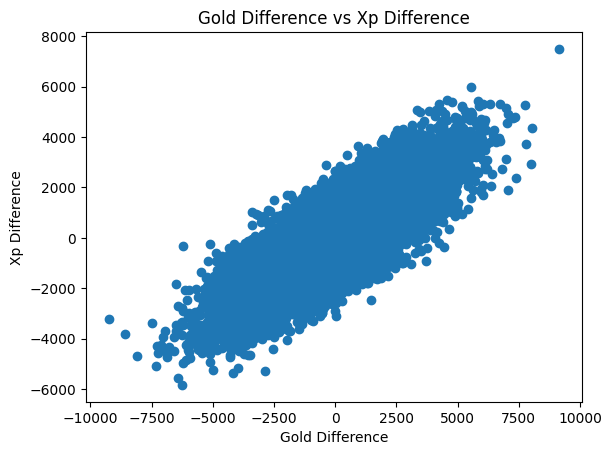

In [ ]:
# Graph of Gold Difference vs XP Difference on train df
plt.scatter(Team_df_train['Gold_Difference'], Team_df_train['Xp_Difference'])
plt.xlabel('Gold Difference')
plt.ylabel('Xp Difference')
plt.title('Gold Difference vs Xp Difference')
plt.show()

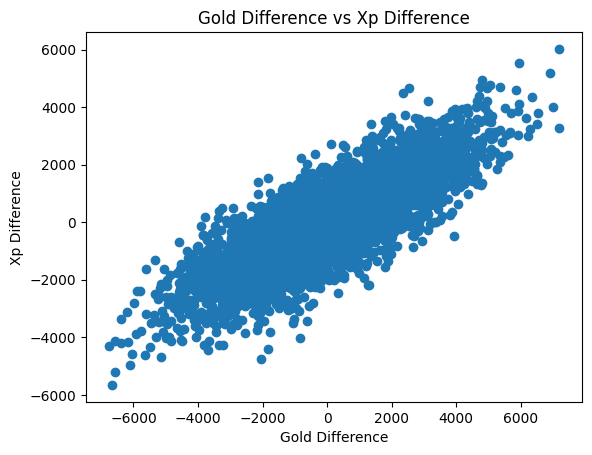

In [ ]:
# Graph of Gold Difference vs XP Difference on test df
plt.scatter(Team_df_test['Gold_Difference'], Team_df_test['Xp_Difference'])
plt.xlabel('Gold Difference')
plt.ylabel('Xp Difference')
plt.title('Gold Difference vs Xp Difference')
plt.show()

From the two graphs above there is a clear positive linear trend between gold difference and xp difference. This make senses as the team with more gold will be stronger and be able to get more xp.

### Graph of Gold Difference vs Kill Difference

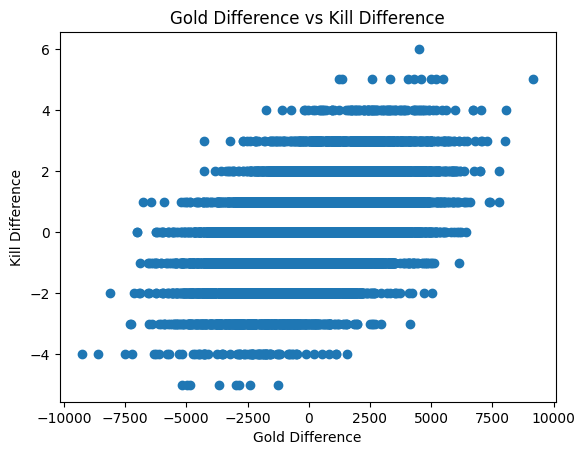

In [ ]:
# Graph of Gold Difference vs Kill Difference on train df
plt.scatter(Team_df_train['Gold_Difference'], Team_df_train['Kill_Difference'])
plt.xlabel('Gold Difference')
plt.ylabel('Kill Difference')
plt.title('Gold Difference vs Kill Difference')
plt.show()

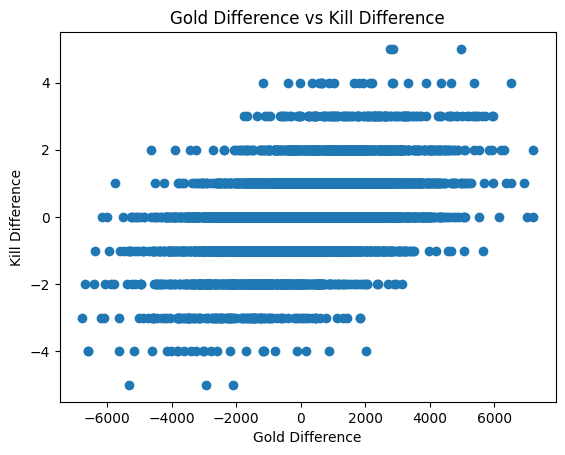

In [ ]:
# Graph of Gold Difference vs Kill Difference on test df
plt.scatter(Team_df_test['Gold_Difference'], Team_df_test['Kill_Difference'])
plt.xlabel('Gold Difference')
plt.ylabel('Kill Difference')
plt.title('Gold Difference vs Kill Difference')
plt.show()

There is a slight positive trend between gold difference and kill difference however it is not that strong and blue or red team can have a positive gold difference but be down in kills.

### Graph of XP Difference vs Gold Difference

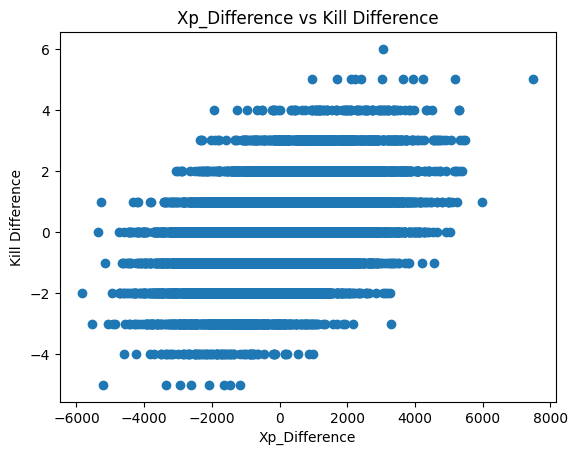

In [ ]:
# Graph of XP Difference vs Kill Differenceon train df
plt.scatter(Team_df_train['Xp_Difference'], Team_df_train['Kill_Difference'])
plt.xlabel('Xp_Difference')
plt.ylabel('Kill Difference')
plt.title('Xp_Difference vs Kill Difference')
plt.show()

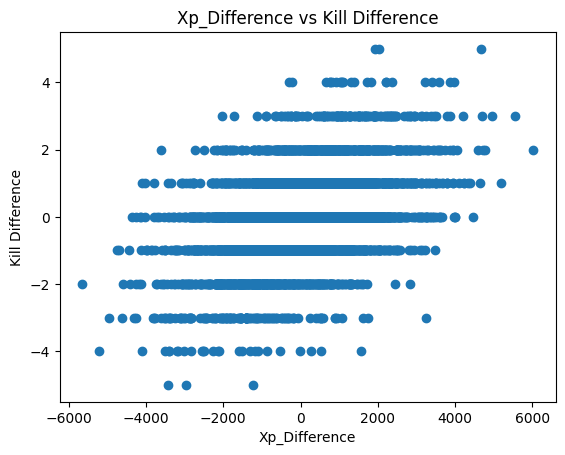

In [ ]:
# Graph of XP Difference vs Kill Difference on test df
plt.scatter(Team_df_test['Xp_Difference'], Team_df_test['Kill_Difference'])
plt.xlabel('Xp_Difference')
plt.ylabel('Kill Difference')
plt.title('Xp_Difference vs Kill Difference')
plt.show()

There is a positive relationship between XP Difference and Kill Difference however it is not as strong as other relationships and a team can have more kills than the other team but be down in XP.

### Graph of Grubs Difference vs Dragon Difference

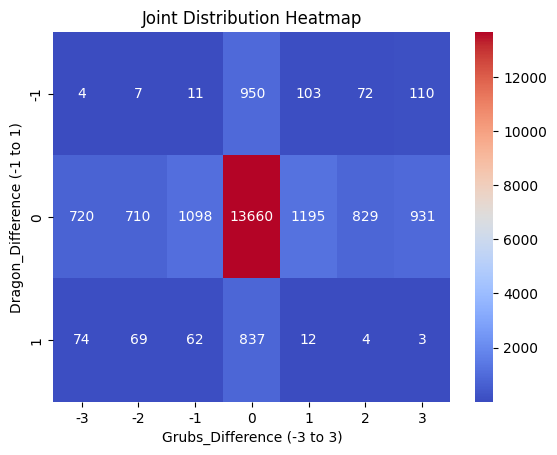

In [ ]:
# Graph of Grubs Difference vs Dragon Difference on train df
ct = pd.crosstab(X_train['Dragon_Difference'], X_train['Grubs_Difference'])

sns.heatmap(ct, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Grubs_Difference (-3 to 3)')
plt.ylabel('Dragon_Difference (-1 to 1)')
plt.title('Joint Distribution Heatmap')
plt.show()


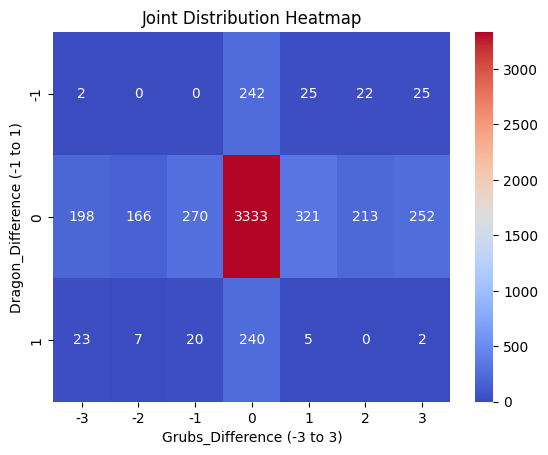

In [ ]:
# Graph of Grubs Difference vs Dragon Difference on test df
ct = pd.crosstab(X_test['Dragon_Difference'], X_test['Grubs_Difference'])

sns.heatmap(ct, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Grubs_Difference (-3 to 3)')
plt.ylabel('Dragon_Difference (-1 to 1)')
plt.title('Joint Distribution Heatmap')
plt.show()

From the graphs above it is clear that most of the data lies within the center of the heatmap where the dragon difference and grubs difference is 0. There is data by the center but it is not much compared to the center square. The reason why most of the data is in the center square for both graphs is because the first dragon spawns at minute 5 however a lot of players won't focuse the dragon into later into the match and grubs spawn at minute 8 meaning there is not a lot of time to get the grubs before the 10 minute mark. If the time point is minute 15 instead of minute 10 there would be more spread in the heatmap.

## Modeling

### Random Forest

In [ ]:
# Importing all of the packages needed
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
# Defining a base Random Forest
rf = RandomForestClassifier(
    random_state=100,
    class_weight="balanced"
)

# Defining a basic parameter grid
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [None, 10, 5],
    "min_samples_split": [2, 4],
    "max_features": ["sqrt", "log2"]
}

# Finding the best parameters
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# Fitting the models
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 4],
                         'n_estimators': [200, 300]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Printing the best parameters
print("Best Parameters:")
print(grid_search.best_params_)


Best Parameters:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 300}


The parameters chosen are a max depth of 5, square root criteria, a min samples split of 4 and n_estimators of 300

In [ ]:
# Assigning the best parameters to the best model
best_model = grid_search.best_estimator_


In [ ]:
# Using the best model to predicted on the test set
y_pred = best_model.predict(X_test)
# Finding the probabilities for the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Printing the classification report, confusion matrix, and AUC
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

        Blue       0.62      0.58      0.60      2787
         Red       0.57      0.61      0.59      2579

    accuracy                           0.59      5366
   macro avg       0.59      0.59      0.59      5366
weighted avg       0.60      0.59      0.59      5366

Confusion Matrix:
[[1624 1163]
 [1015 1564]]
ROC AUC: 0.6331300825733168


The classification report shows that the Random Forest has precision, recall and F1 score all hover around .6 and also it is similar for accuracy.  The confusion matrix shows that overall the model choses more true positives and true negatives than false positives and false negatives. The AUC is 0.63 which is pretty good for predicting League of Legends matches at minute 10 since matches can often flip flop espically since the matches chosen are Gold through Diamond which is not the best elo.

In [ ]:
# Displaying the feature importance
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feature_importance_df)



                     feature  importance
0        TOP_gold_difference    0.161509
12   UTILITY_gold_difference    0.150385
3     JUNGLE_gold_difference    0.147653
6     MIDDLE_gold_difference    0.134080
9     BOTTOM_gold_difference    0.133648
10      BOTTOM_xp_difference    0.047840
13     UTILITY_xp_difference    0.043433
4       JUNGLE_xp_difference    0.043043
16          Grubs_Difference    0.035573
1          TOP_xp_difference    0.033878
7       MIDDLE_xp_difference    0.032428
15         Dragon_Difference    0.026059
2       TOP_kills_difference    0.002567
5    JUNGLE_kills_difference    0.002227
11   BOTTOM_kills_difference    0.002083
14  UTILITY_kills_difference    0.001885
8    MIDDLE_kills_difference    0.001707


The most important features were gold difference as it can allow players to buy items that makes the player more powerful. It is interesting that Top and Utility had the most importance. XP difference was seen as the second most important as the more xp a player has the more raw stats the player will have. Grubs and dragons were seen middle of the pack but grubs were seen as more import objective to get. Lastly kill difference was seen as the least important type of variable which is surprising since kills is seen as an important aspect of winning the game.

### LightGBM

In [ ]:
# Importing the necessary package for LightGBM
import lightgbm as lgb

In [ ]:
# Defining a parameter grid to tune
param_grid = {
    "num_leaves": [31, 63],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [300, 600]
}

# Defining a base LightGBM
lgb_tuned = lgb.LGBMClassifier(
    objective="binary",
    random_state=100
)

# Tuning the LightGBM
grid = GridSearchCV(
    lgb_tuned,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

# Fitting the grid
grid.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 10521, number of negative: 10940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 21461, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490238 -> initscore=-0.039053
[LightGBM] [Info] Start training from score -0.039053


GridSearchCV(cv=3,
             estimator=LGBMClassifier(objective='binary', random_state=100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [-1, 10, 20], 'n_estimators': [300, 600],
                         'num_leaves': [31, 63]},
             scoring='roc_auc', verbose=2)

In [ ]:
# Assigning the best parameters to a model
best_model = grid.best_estimator_

# Printing the best parameters
print("Best Parameters:")
print(grid.best_params_)

Best Parameters:
{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31}


The parameters chosen were a learning rate of 0.01, no max depth, number of estimators of 300, and number of leaves of 31.

In [ ]:
# Fitting the model
best_model.fit(X_train, y_train)

# Making predictions on the test set
final_preds = best_model.predict(X_test)
final_proba = best_model.predict_proba(X_test)[:, 1]

# Printing the final AUC
print("Final AUC:", roc_auc_score(y_test, final_proba))


[LightGBM] [Info] Number of positive: 10521, number of negative: 10940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 21461, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490238 -> initscore=-0.039053
[LightGBM] [Info] Start training from score -0.039053
Final AUC: 0.6404764796617766


The final AUC for the LightGBM is 0.64 which is better than the random forest model. This can because LightGBM is more of a advanced method that can potentially pick up on patterns that random forest can not due to the way LightGBM splits. A AUC of 0.64 good given the context of that matches are not decided at minute 10 and teams can throw the lead when they are winning and that can be hard for a model to pick up on.

In [ ]:
# Making a feature importance df
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)



,feature,importance
1,TOP_xp_difference,3008
0,TOP_gold_difference,2958
16,Grubs_Difference,1398
15,Dragon_Difference,1219
2,TOP_kills_difference,417
5,JUNGLE_kills_difference,0
6,MIDDLE_gold_difference,0
3,JUNGLE_gold_difference,0
4,JUNGLE_xp_difference,0
8,MIDDLE_kills_difference,0


Looking at the feature importance it is interesting to note that the LightGBM model only used 5 features in the model. Neutral objectives taken seemed to have an impact on who was going to win the match with both dragon and grubs having importance. Top lane seems to have most impact out of every lane and variable with it having the all 3 of it varable having importance and both xp and gold for top lane being the top two most important variable. The LightGBM seems to think that the top lane has the most impact on winning a match in gold through diamond rank at the 10 minute mark.

### Neural Network

In [ ]:
# Loading the necessary packages
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Scaling the data for the Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Building the model
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [ ]:
# Setting up early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

# Reducing learning rate when needed
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

In [ ]:
# Changing the response variables into integers
y_train = y_train.map({"Blue": 1, "Red": 0})
y_test = y_test.map({"Blue": 1, "Red": 0})



In [ ]:
# Training the model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/150
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5355 - auc: 0.5516 - loss: 0.7889 - val_accuracy: 0.5912 - val_auc: 0.6226 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 2/150
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5556 - auc: 0.5835 - loss: 0.6984 - val_accuracy: 0.5807 - val_auc: 0.6275 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 3/150
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5661 - auc: 0.5975 - loss: 0.6840 - val_accuracy: 0.5903 - val_auc: 0.6293 - val_loss: 0.6665 - learning_rate: 0.0010
Epoch 4/150
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5738 - auc: 0.6096 - loss: 0.6768 - val_accuracy: 0.5891 - val_auc: 0.6304 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 5/150
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5777 - auc: 0.6072 - loss: 0.6756 - val_accuracy: 0.5870 - val_auc: 0.6308 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 6/150
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5897

In [ ]:
# Predicting on the test set
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Printing out the results
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC AUC: 0.6444014634499927


The model had a AUC of 0.644 which is the best performing model out of all of the models tested. It slightly outperformed the LightGBM by 0.004. This might have happened because neural networks can pick up on trends that forest models can not pick up on due to the structure of the models. On top of that, neural networks can find hidden and complex patterns that a forest model may have trouble picking up on. It would be interesting to see with more data and a more complex neural network model would lead to vastly greater AUC score.

## Conclusion and Improvements

### Conclusion

It seems that Top lane was the most important lane when determining the outcome of the matches and gold was the most important stat as well. The model that performed the best in predicting what team won based on the 10 minute mark of the game was the Neural Network model with an AUC of 0.644, followed by the LightGBM model with an AUC of 0.640, and the worst performing model was the Random Forest model with an AUC of 0.604. With more data, more tuning, and more complex parameters the best model could easily change along with the AUC scores. The models was kept simple with basic tuning and kept a lot of the default parameters. The way the data was set up was that each position had three variables for each team, kills, xp, and gold. There were two variables measuring the neutral objectives taken (dragon and grubs taken). Each variable was then calculated into finding the difference between the blue team and red team with positives being blue having more. Doing this reduced the number of columns and made the data more easy to understand however it may have resulted in some information loss. The data used was collected near the end of Season 15 and the game changed drastically in Season 16. The change in Seasons can lead to drastically different predictive power and different important variables.

### Improvements

The Riot API collection process did not work correctly as intended. Many variables that I wanted to have in the dataset did not pull correctly leading to those variables having to be dropped from the dataset such as wards placed, wards killed, and cs. Having those variables in the dataset could have lead to more complex patterns being caught and lead to an increase score in AUC. Also, having the threshold adjusted could increase AUC. Another more interesting improvement in including the champions the person is playing as certain champions excel at certain parts of the game. I could have also used more models or spent more time building a more complex model however I was worried about the time it would have taken to run those models. Collecting more data was also an improvement that could have been done as that can help the models pick up on the patterns. Lastly, including the rank of each positions for each team can lead to more information about the game and increase predictive performance.
